# MNIST Digit Recognition ANN

This notebook is a tutorial on how to train and test a neural network to identify hand written digits of the MNIST dataset.

In [136]:
# Import libraries
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

A `torch.device` is an object representing the device on which a `torch.Tensor` is or will be allocated.

The `torch.device` contains a device type ('cpu', 'cuda' or 'mps') and optional device ordinal for the device type. If the device ordinal is not present, this object will always represent the current device for the device type.

A `torch.Tensor`’s device can be accessed via the `Tensor.device` property.

In [137]:
# Check if CUDA is available and set the device accordingly
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

Data normalisation is important as it standardises the range of input features. This is done to ensure that no particular feature dominates the learning process simply because of its scale.

The MNIST dataset consists of grayscale images, and the pixel intensities are originally between 0 and 255. The `transforms.ToTensor()` transform scales these values to be between 0 and 1. The `transforms.Normalize((0.5,), (0.5,))` transform then shifts the pixel values to be between -1 and 1. When the data is centered around 0 (i.e., in the range -1 to 1), the gradients during backpropagation are less likely to vanish or explode, which can lead to more stable training. This is particularly important for deeper networks.

The two arguments to `transforms.Normalize` are the mean and standard deviation respectively. In this case, we assume the mean and standard deviation to be 0.5, which is a rough estimate for the MNIST dataset after scaling the pixel intensities to the range 0 to 1. This normalization helps the neural network learn more effectively.

`transforms.Compose()` is used to chain together multiple multiple image transformations into a single transform.

In [138]:
# Define a transform to normalize the data
transform = transforms.Compose(
    transforms=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
transform

Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

The `datasets.MNIST` class in PyTorch’s torchvision module is used to load the MNIST (Modified National Institute of Standards and Technology) dataset. The MNIST dataset is a large database of handwritten digits that is commonly used for training image processing systems.

- `root` is the path where the MNIST data is stored or downloaded to.
- `train` is a boolean flag that indicates whether to load the training set (60,000 images and labels) or the testing set (10,000 images and labels).
- `download` is a boolean flag that indicates whether to download the dataset from the internet ifv it not available at the `root` directory.
- `transform` is a transform that is applied.

In [139]:
# Download the training data
trainset = datasets.MNIST(
    root="~/.pytorch/MNIST_data/",
    download=True,
    train=True,
    transform=transform,
)
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: C:\Users\Brogan.McCawley/.pytorch/MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

The `DataLoader` helps to load and preprocess data conveniently. It automatically divides the data into batches of a specified size, which can then be processed independently. This is particularly useful when working with large datasets that won't fit entirely in memory. It also shuffles the data at each epoch, ensuring that the model gets different batches in each epoch.

In [140]:
# Load the dataset
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
trainloader

In [141]:
# Explore the dataset
trainloader.dataset[0][0][0]

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

Plot MNIST images.

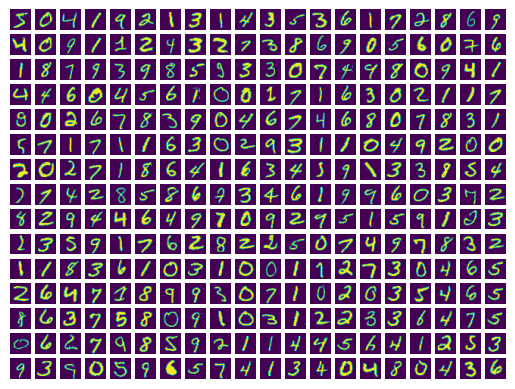

In [142]:
nrows = 15
ncols = 20
fig, axs = plt.subplots(nrows, ncols)
for i, ax in enumerate(axs.flat):
    ax.imshow(trainloader.dataset[i][0][0])
    ax.axis("off")

The `nn.Sequential()` class is a container where you specify the modules in the order they are added and the order they should execute. The input is passed through all the modules in the order they are defined to produce the output. In this case, the input would be passed through the Linear layer, then ReLU, then the next Linear layer, and so on.

This is a common architecture for simple feed-forward neural networks.

- `nn.Linear(784, 128)`: This is the input layer of the network. `nn.Linear()` take arguments `in_features`, `out_features` and `bias`. It applies a linear transformation to the incoming data: y = xA^T + b, where x is the input, A is the matrix of weights (of shape `(out_features, in_features)`), b is the bias (of shape `(out_features)`) and y is the output. The layer expects input of size 784 (i.e. flattened 28x28 MNIST image), and it outputs size 128. The parameters A and b are initialised randomly.
- `nn.ReLU()`: This is the activation function for the first layer. It operates element-wise on the output of the previous layer.
- `nn.Linear(128, 64)`: This is the first hidden layer. It expects input of size 128 (the output of the previous layer), and it outputs size 64.
- `nn.Linear(64, 10)`: This is the output layer. It expects input of size 64 and it outputs size 10. The output size corresponds to the number of classes to be classified.
- `nn.LogSoftmax(dim=1)`: This is the activation function for the output layer. Softmax squashes the output of the previous layer to be between 0 and 1, and also ensures that the sum of all output values is 1. This makes it suitable for multi-class classification problems. The LogSoftmax is the logarithm of the softmax output and often used in conjunction with the negative log likelihood loss (nn.NLLLoss()), to train the network.

In [143]:
# Define a simple ANN with two hidden layers and one output layer
model = nn.Sequential(
    nn.Linear(784, 128),  # Input layer (784 inputs, 128 outputs)
    nn.ReLU(),  # Activation function (ReLU)
    nn.Linear(128, 64),  # Hidden layer (128 inputs, 64 outputs)
    nn.ReLU(),  # Activation function (ReLU)
    nn.Linear(64, 10),  # Output layer (64 inputs, 10 outputs)
    nn.LogSoftmax(dim=1),  # Activation function (LogSoftmax)
)

Move the model parameters to the CPU or GPU-specific memory. Typically, CPU memory is just RAM, but GPU's have separate memory. This is necessary because a GPU can only access its own memory space.

In [144]:
# Move the model to the device (GPU if available, else CPU)
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)

The Negative Log Likelihood (NLL) Loss function is a common loss function used for classification problems in machine learning.

The ‘negative’ part of NLL means multiplying by -1. Most machine learning frameworks only have minimisation optimisations, but we want to maximise the probability of choosing the correct category. We can maximise by minimising the negative log likelihood.

The ‘log’ part is used because we are calculating the product of a number of things. Remember that log(a*b) = log(a) + log(b). We wrap everything with a logarithm because computers can lose precision when multiplying numbers that are too high or too low. By using the log of a number like 1e-100, the log becomes something close to -230, which is much easier for a computer to represent.

The ‘likelihood’ refers to the chances of some calculated parameters producing some known data. In machine learning, we are interested in obtaining some parameters to match the pattern inherent to the data.

For example, if a model outputs probabilities like [0.1, 0.3, 0.5, 0.1] for 4 possible classes, and the true answer is the fourth class (represented as a vector [0, 0, 0, 1]), the likelihood of the current state of the model producing the input is: 0\*0.3 + 0\*0.1 + 0\*0.5 + 1\*0.1 = 0.1. The NLL would then be -ln(0.1) = 2.3.

In summary, the NLL function is used to measure the performance of a model. The better the prediction, the lower the NLL loss, which is exactly what we want.

The figure shows that as the dot product of the output and the expected vectors tends to 1 (indicating a perfect match) the function minimises.

![nlll image](nlll.png)

In [145]:
# Define the loss function (Negative Log Likelihood Loss)
# nn.NLLLoss() itself is a class, not a function
criterion = nn.NLLLoss()

The opimiser is used to update the parameters (i.e., weights and biases) of the model during training.

Stochastic Gradient Descent performs a parameter update for each training example and label, which is much more computationally efficient when you have a lot of data. The way it works is that for each training example, it computes the gradient of the error with respect to the model parameters and then updates the parameters in the direction that reduces the error.

The loss is computed for the forward pass, and then the gradient is computed the gradients with the backward pass. Finally, the parameters are updated with the optimiser.

`model.parameters()` passes the weights and biases of the model to the optimiser, which updates them.

The term “stochastic” in Stochastic Gradient Descent (SGD) refers to the randomness introduced in the optimisation process. In SGD, instead of using the entire dataset for each iteration as in traditional Gradient Descent, only a single random training example (or a small batch) is selected to calculate the gradient and update the model parameters.

This random selection introduces randomness into the optimisation process, hence the term “stochastic” in Stochastic Gradient Descent. The advantage of using SGD is its computational efficiency, especially when dealing with large datasets. By using a single example or a small batch, the computational cost per iteration is significantly reduced compared to traditional Gradient Descent methods that require processing the entire dataset.

However, since only one sample from the dataset is chosen at random for each iteration, the path taken by the algorithm to reach the minima is usually noisier than your typical Gradient Descent algorithm. This is a trade-off for the increased computational efficiency.

In [146]:
# Define the optimizer (Stochastic Gradient Descent) with learning rate 0.003
optimizer = optim.SGD(model.parameters(), lr=0.003)

An epoch refers to one complete pass through the entire training dataset during the training process. During an epoch, every training sample in the dataset is processed by the model, and its weights and biases are updated in accordance with the computed loss or error.

Increasing the number of epochs generally improves the performance of the model by allowing it to learn more complex patterns in the data.
However, if there are too many epochs, the model may overfit the training data to the point that it performs poorly on unseen data.
It’s important to monitor the model’s performance on a validation set during training and stop training when the validation performance starts to decay. This technique is known as early stopping.

In [147]:
# Set the number of training epochs
epochs = 20

- `for images, labels in trainloader:` This loop iterates over the training data in batches of 64 (as set when `trainloader` was defined). In each iteration, it provides a batch of images and their corresponding labels.

- `images = images.view(images.shape[0], -1)` The view method reshapes a tensor into the number of dimensions, and number of elements per dimension, as provided in the arguments. Where -1 is given, the method will caculate the number of elements per dimension itself, so long as the others are given. In this instance, images maintains the same number of elements in the first dimension (64 - corresponding to the number of images in the batch) and flattens the 28x28 pixel image into a single vector.

- `images, labels = images.to(device), labels.to(device)` This line moves the images and labels to the device (CPU or GPU) for computation.

- `optimizer.zero_grad()` This line clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).

- `output = model(images)` This line performs the forward pass of the model. It passes the images through the model and gets the output.

- `loss = criterion(output, labels)` This line computes the loss function between the model output and the actual labels.

- `loss.backward()` This line performs the backpropagation, which calculates the gradient of the loss with respect to the model parameters.

- `optimizer.step()` This line performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the learning rate.

- `running_loss += loss.item()` This line adds the current loss to the running loss. loss.item() gets the scalar value held in the loss.

- `print(f"Training loss: {running_loss/len(trainloader)}")` After each epoch, it prints the average loss per batch of data.

In summary, this code is training a model on a dataset for a specified number of epochs. In each epoch, it iterates over all the data, computes the forward pass, calculates the loss, performs backpropagation to compute the gradients, and then updates the model parameters.

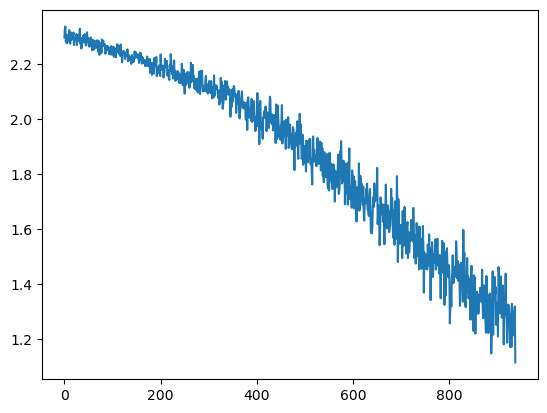

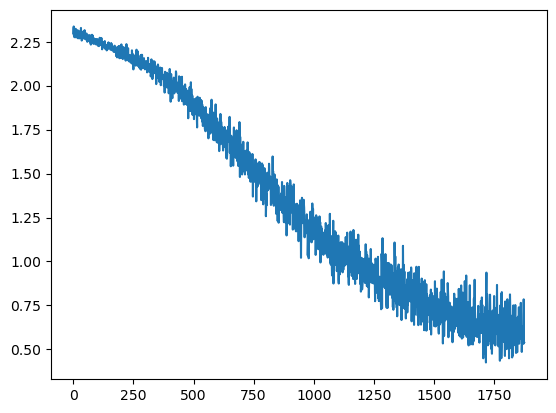

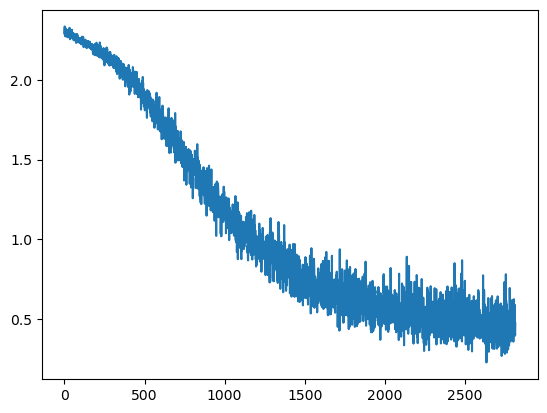

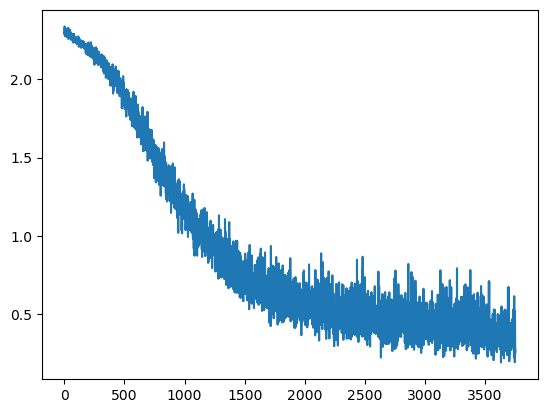

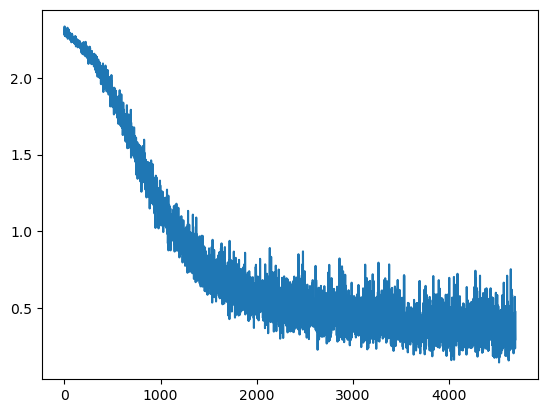

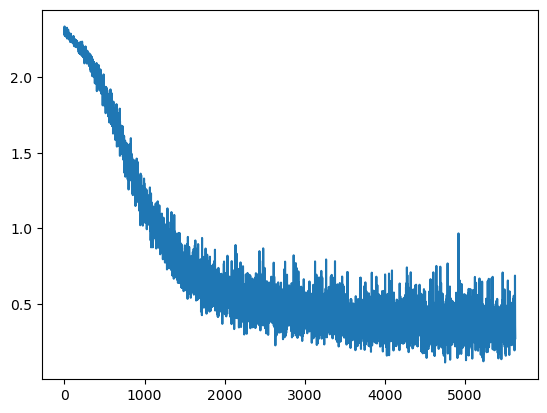

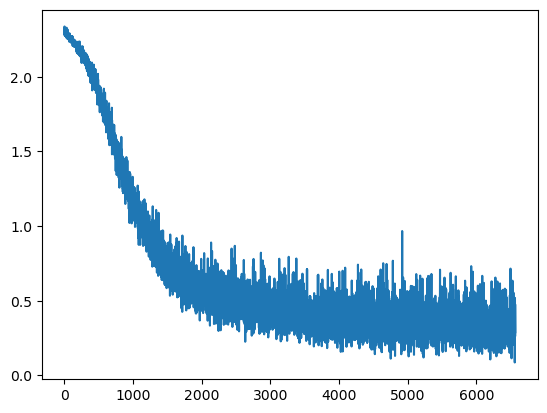

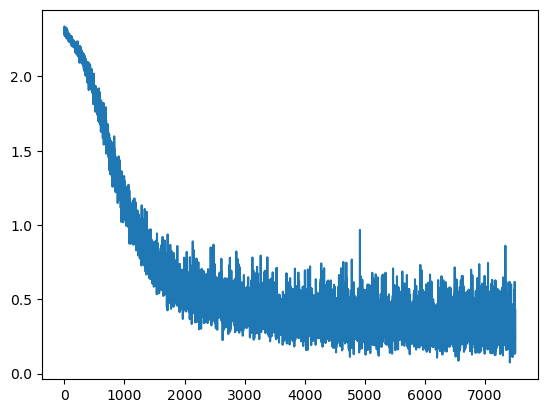

In [148]:
# Start the training loop
loss_list = []
for _ in range(epochs):
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Training pass
        optimizer.zero_grad()  # Clear the gradients

        output = model(images)  # Forward pass
        # Output is a tensor with shape [64, 10]
        # The second dimension is a vector of likelihood of each digit
        loss = criterion(output, labels)  # Compute the loss
        # Loss is a tensor of one element
        # It is also associated with a function to calculate the gradient
        # Backpropagation
        loss.backward()  # Compute the gradients

        # Update weights
        optimizer.step()  # Update the weights

        loss_list.append(loss.item())
    plt.plot(loss_list)
    plt.show()

In [135]:
# Download and load the testing data
testset = datasets.MNIST(
    "~/.pytorch/MNIST_data/", download=True, train=False, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Initialize the test loss and the accuracy
test_loss = 0
accuracy = 0

# Switch model to evaluation mode. This means that dropout and batch norm are disabled.
model.eval()

# Turn off gradients for testing
with torch.no_grad():
    for images, labels in testloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        log_ps = model(images)

        # Compute the loss
        test_loss += criterion(log_ps, labels)

        # Get the class probabilities
        ps = torch.exp(log_ps)

        # Get the top result
        top_p, top_class = ps.topk(1, dim=1)

        # Check how many of the classes were correct?
        equals = top_class == labels.view(*top_class.shape)

        # Calculate the accuracy
        accuracy += torch.mean(equals.type(torch.FloatTensor))

# Switch model back to train mode
model.train()

# Print the test loss and the accuracy
print(f"Test loss: {test_loss/len(testloader)}")
print(f"Test accuracy: {accuracy/len(testloader)}")

Test loss: 0.35893863439559937
Test accuracy: 0.8966958522796631
